In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 720.2179, train_label_loss: 2.8238, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11638.2488, train_label_loss: 2.7253, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11662.6224, train_label_loss: 2.5891, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11723.6941, train_label_loss: 2.5074, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11781.3484, train_label_loss: 2.3486, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11741.9707, train_label_loss: 2.2373, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11695.6295, train_label_loss: 2.0611, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11679.8449, train_label_loss: 1.8504, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11717.8782, train_label_loss: 1.8777, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11645.0447, train_label_loss: 1.5474, 


epoch: 1, source_val_acc_label: 0.5688, source_val_label_loss: 1.5241, target_val_acc_label: 0.5688, target_val_label_loss: 1.5241, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 55.6725, train_label_loss: 1.5158, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11542.3127, train_label_loss: 1.4071, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11623.1648, train_label_loss: 1.2934, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11655.1425, train_label_loss: 1.3142, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11591.7269, train_label_loss: 1.1657, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11661.0826, train_label_loss: 1.1772, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11646.2193, train_label_loss: 0.9354, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11642.0523, train_label_loss: 0.9201, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11570.2943, train_label_loss: 0.8622, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11587.3522, train_label_loss: 0.8427, 


epoch: 2, source_val_acc_label: 0.8201, source_val_label_loss: 0.7253, target_val_acc_label: 0.8201, target_val_label_loss: 0.7253, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 62.8920, train_label_loss: 0.6666, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11560.9182, train_label_loss: 0.6982, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11668.7694, train_label_loss: 0.6388, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11691.2797, train_label_loss: 0.5685, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11606.1448, train_label_loss: 0.6146, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11613.3969, train_label_loss: 0.5173, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11523.7796, train_label_loss: 0.7165, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11693.3332, train_label_loss: 0.6045, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11656.3336, train_label_loss: 0.4305, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11470.3122, train_label_loss: 0.4352, 


epoch: 3, source_val_acc_label: 0.8893, source_val_label_loss: 0.4449, target_val_acc_label: 0.8893, target_val_label_loss: 0.4449, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 63.9033, train_label_loss: 0.4867, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11546.9562, train_label_loss: 0.4713, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11676.0927, train_label_loss: 0.4915, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12614.7085, train_label_loss: 0.5104, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12303.2895, train_label_loss: 0.4135, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11663.3753, train_label_loss: 0.5086, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11645.1565, train_label_loss: 0.8058, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11630.9457, train_label_loss: 0.3214, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11738.9503, train_label_loss: 0.3317, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11716.3768, train_label_loss: 0.3505, 


epoch: 4, source_val_acc_label: 0.8949, source_val_label_loss: 0.3442, target_val_acc_label: 0.8949, target_val_label_loss: 0.3442, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 63.7369, train_label_loss: 0.2976, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11628.5119, train_label_loss: 0.2726, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11756.3954, train_label_loss: 0.3128, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11709.8365, train_label_loss: 0.2488, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11770.3727, train_label_loss: 0.2420, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11635.5911, train_label_loss: 0.2944, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11624.2829, train_label_loss: 0.2982, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11742.1431, train_label_loss: 0.2654, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11753.5091, train_label_loss: 0.2235, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11743.3668, train_label_loss: 0.2879, 


epoch: 5, source_val_acc_label: 0.9278, source_val_label_loss: 0.2641, target_val_acc_label: 0.9278, target_val_label_loss: 0.2641, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.0720, train_label_loss: 0.1826, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11728.2236, train_label_loss: 0.1344, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11726.6719, train_label_loss: 0.1758, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11758.6595, train_label_loss: 0.2343, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11726.4450, train_label_loss: 0.1690, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11752.7501, train_label_loss: 0.3861, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11795.8405, train_label_loss: 0.3042, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11790.2302, train_label_loss: 0.2725, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11722.9572, train_label_loss: 0.1968, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11836.0059, train_label_loss: 0.1990, 


epoch: 6, source_val_acc_label: 0.9369, source_val_label_loss: 0.2105, target_val_acc_label: 0.9369, target_val_label_loss: 0.2105, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 64.3224, train_label_loss: 0.1671, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11777.5951, train_label_loss: 0.1758, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11771.1617, train_label_loss: 0.2493, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11761.8668, train_label_loss: 0.2120, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11631.6981, train_label_loss: 0.2340, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11729.7153, train_label_loss: 0.3020, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11816.8262, train_label_loss: 0.2544, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 12530.5404, train_label_loss: 0.1597, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 12944.8588, train_label_loss: 0.1689, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 12985.6722, train_label_loss: 0.1506, 


epoch: 7, source_val_acc_label: 0.9466, source_val_label_loss: 0.1826, target_val_acc_label: 0.9466, target_val_label_loss: 0.1826, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 71.8486, train_label_loss: 0.1751, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 12805.9011, train_label_loss: 0.2673, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 13245.7323, train_label_loss: 0.2602, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 13972.8391, train_label_loss: 0.1994, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 12975.9023, train_label_loss: 0.2031, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 12932.6841, train_label_loss: 0.1664, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 12857.3710, train_label_loss: 0.4065, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 13034.8292, train_label_loss: 0.1463, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 13086.2393, train_label_loss: 0.1686, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 12995.6725, train_label_loss: 0.1536, 


epoch: 8, source_val_acc_label: 0.9464, source_val_label_loss: 0.2182, target_val_acc_label: 0.9464, target_val_label_loss: 0.2182, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 73.0841, train_label_loss: 0.1710, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 12876.8149, train_label_loss: 0.1457, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 12885.5366, train_label_loss: 0.1656, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 12985.4389, train_label_loss: 0.1863, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 13053.6732, train_label_loss: 0.1508, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 12835.3399, train_label_loss: 0.1484, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 13009.3396, train_label_loss: 0.2449, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 12998.3043, train_label_loss: 0.1368, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 13014.8834, train_label_loss: 0.1692, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 12935.5464, train_label_loss: 0.1695, 


epoch: 9, source_val_acc_label: 0.9416, source_val_label_loss: 0.1914, target_val_acc_label: 0.9416, target_val_label_loss: 0.1914, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 73.1857, train_label_loss: 0.1079, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 12877.6015, train_label_loss: 0.1169, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 12977.3115, train_label_loss: 0.1365, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 13022.9022, train_label_loss: 0.1430, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 13042.3091, train_label_loss: 0.1717, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 13066.2995, train_label_loss: 0.1716, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 13018.2782, train_label_loss: 0.1258, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 12971.1414, train_label_loss: 0.1043, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 13001.1148, train_label_loss: 0.1415, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 12874.3640, train_label_loss: 0.1608, 


epoch: 10, source_val_acc_label: 0.9422, source_val_label_loss: 0.1740, target_val_acc_label: 0.9422, target_val_label_loss: 0.1740, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 74.0644, train_label_loss: 0.2203, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 12940.4262, train_label_loss: 0.1942, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 13028.7693, train_label_loss: 0.1114, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 12997.0209, train_label_loss: 0.1668, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 12916.0917, train_label_loss: 0.1704, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 12964.4697, train_label_loss: 0.1367, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 13303.2292, train_label_loss: 0.1054, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 13987.3696, train_label_loss: 0.0864, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 13030.6779, train_label_loss: 0.1256, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 12843.9049, train_label_loss: 0.1280, 


epoch: 11, source_val_acc_label: 0.9486, source_val_label_loss: 0.2314, target_val_acc_label: 0.9486, target_val_label_loss: 0.2314, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 72.8367, train_label_loss: 0.1162, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 12952.1997, train_label_loss: 0.1247, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 13033.8482, train_label_loss: 0.2892, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 13024.8927, train_label_loss: 0.1737, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 13066.8015, train_label_loss: 0.0812, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 12955.4618, train_label_loss: 0.0849, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 13008.2341, train_label_loss: 0.1508, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 12842.2875, train_label_loss: 0.1715, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 12918.5603, train_label_loss: 0.0955, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 12947.5057, train_label_loss: 0.0518, 


epoch: 12, source_val_acc_label: 0.9505, source_val_label_loss: 0.1487, target_val_acc_label: 0.9505, target_val_label_loss: 0.1487, 


New best
epoch: 13, [batch: 1 / 1400], examples_per_second: 72.2424, train_label_loss: 0.1171, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 12948.8195, train_label_loss: 0.1099, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 13018.8690, train_label_loss: 0.0666, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 12962.8352, train_label_loss: 0.0718, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 13052.6395, train_label_loss: 0.1064, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 13055.3783, train_label_loss: 0.0700, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 13050.3754, train_label_loss: 0.1011, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 13062.8477, train_label_loss: 0.1577, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 13030.6576, train_label_loss: 0.1120, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 12990.2304, train_label_loss: 0.1199, 


epoch: 13, source_val_acc_label: 0.9492, source_val_label_loss: 0.1656, target_val_acc_label: 0.9492, target_val_label_loss: 0.1656, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 73.1454, train_label_loss: 0.1122, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 12921.2666, train_label_loss: 0.1168, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 12908.0220, train_label_loss: 0.1284, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 12948.3086, train_label_loss: 0.1442, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 12986.6998, train_label_loss: 0.0731, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 12941.6893, train_label_loss: 0.0862, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 12949.4285, train_label_loss: 0.0918, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 13013.1393, train_label_loss: 0.0926, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 13044.8579, train_label_loss: 0.0758, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 12944.5600, train_label_loss: 0.0907, 


epoch: 14, source_val_acc_label: 0.9519, source_val_label_loss: 0.1656, target_val_acc_label: 0.9519, target_val_label_loss: 0.1656, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 77.3239, train_label_loss: 0.0554, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 13387.4950, train_label_loss: 0.1031, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 12939.9291, train_label_loss: 0.0966, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 12893.3327, train_label_loss: 0.0907, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 12989.6871, train_label_loss: 0.0588, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 12929.1647, train_label_loss: 0.1059, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 12939.1405, train_label_loss: 0.0865, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 12900.7108, train_label_loss: 0.0714, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 12936.9023, train_label_loss: 0.0742, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 12908.0309, train_label_loss: 0.0798, 


epoch: 15, source_val_acc_label: 0.9614, source_val_label_loss: 0.1271, target_val_acc_label: 0.9614, target_val_label_loss: 0.1271, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 72.3225, train_label_loss: 0.1054, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 12834.6808, train_label_loss: 0.0877, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 12919.4041, train_label_loss: 0.1606, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 12969.0846, train_label_loss: 0.0810, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 12961.1274, train_label_loss: 0.0680, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 12929.8520, train_label_loss: 0.1092, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 12897.0516, train_label_loss: 0.1860, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 12897.6027, train_label_loss: 0.0640, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 12928.7221, train_label_loss: 0.0736, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 12896.8149, train_label_loss: 0.0739, 


epoch: 16, source_val_acc_label: 0.9590, source_val_label_loss: 0.1266, target_val_acc_label: 0.9590, target_val_label_loss: 0.1266, 


epoch: 17, [batch: 1 / 1400], examples_per_second: 72.9874, train_label_loss: 0.0697, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 12824.7374, train_label_loss: 0.0916, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 12874.3133, train_label_loss: 0.1172, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 12907.9245, train_label_loss: 0.0941, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 12865.7496, train_label_loss: 0.0967, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 12919.0776, train_label_loss: 0.0927, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 12827.2898, train_label_loss: 0.1130, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 12916.8242, train_label_loss: 0.0472, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 12964.9057, train_label_loss: 0.1181, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 12885.6979, train_label_loss: 0.0985, 


epoch: 17, source_val_acc_label: 0.9561, source_val_label_loss: 0.2009, target_val_acc_label: 0.9561, target_val_label_loss: 0.2009, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 71.9573, train_label_loss: 0.0817, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 13581.0200, train_label_loss: 0.0515, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 13842.9699, train_label_loss: 0.0867, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 13906.1617, train_label_loss: 0.0938, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 13974.5745, train_label_loss: 0.1551, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 13986.8100, train_label_loss: 0.0729, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 13999.0616, train_label_loss: 0.0828, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 14012.6774, train_label_loss: 0.1367, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 14017.2350, train_label_loss: 0.0480, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 13401.5389, train_label_loss: 0.0459, 


epoch: 18, source_val_acc_label: 0.9574, source_val_label_loss: 0.1271, target_val_acc_label: 0.9574, target_val_label_loss: 0.1271, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 64.2270, train_label_loss: 0.0461, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 11671.8753, train_label_loss: 0.0845, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 11759.8553, train_label_loss: 0.1228, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 11734.2971, train_label_loss: 0.0855, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 11784.9302, train_label_loss: 0.0687, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11598.9036, train_label_loss: 0.0995, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11717.9750, train_label_loss: 0.0535, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11655.4516, train_label_loss: 0.1166, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11757.3278, train_label_loss: 0.0970, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11557.4028, train_label_loss: 0.0969, 


epoch: 19, source_val_acc_label: 0.9660, source_val_label_loss: 0.1359, target_val_acc_label: 0.9660, target_val_label_loss: 0.1359, 


New best
epoch: 20, [batch: 1 / 1400], examples_per_second: 63.5478, train_label_loss: 0.0286, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11735.7359, train_label_loss: 0.0441, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11605.7595, train_label_loss: 0.1032, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 11708.0945, train_label_loss: 0.0963, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 11657.9680, train_label_loss: 0.0778, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 11661.8751, train_label_loss: 0.0775, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 11561.0666, train_label_loss: 0.0886, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 11724.6871, train_label_loss: 0.0693, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 11696.8216, train_label_loss: 0.0580, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 11707.0806, train_label_loss: 0.0553, 


epoch: 20, source_val_acc_label: 0.9598, source_val_label_loss: 0.1524, target_val_acc_label: 0.9598, target_val_label_loss: 0.1524, 


epoch: 21, [batch: 1 / 1400], examples_per_second: 65.1789, train_label_loss: 0.0638, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 11678.2281, train_label_loss: 0.0341, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 11680.0282, train_label_loss: 0.0450, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 11713.4005, train_label_loss: 0.0597, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 11747.6434, train_label_loss: 0.0824, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 11654.6256, train_label_loss: 0.1206, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 11691.4997, train_label_loss: 0.0752, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 11683.0692, train_label_loss: 0.0607, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 11705.7186, train_label_loss: 0.0691, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 11644.2220, train_label_loss: 0.0523, 


epoch: 21, source_val_acc_label: 0.9483, source_val_label_loss: 0.2086, target_val_acc_label: 0.9483, target_val_label_loss: 0.2086, 


epoch: 22, [batch: 1 / 1400], examples_per_second: 65.2759, train_label_loss: 0.0641, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 11641.0719, train_label_loss: 0.0624, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 11783.4373, train_label_loss: 0.1249, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 11696.4976, train_label_loss: 0.1625, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 11657.7963, train_label_loss: 0.0667, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 11678.7814, train_label_loss: 0.0959, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 11635.9712, train_label_loss: 0.0616, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 11692.7238, train_label_loss: 0.0529, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 11680.6998, train_label_loss: 0.1204, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 11710.7998, train_label_loss: 0.0839, 


epoch: 22, source_val_acc_label: 0.9639, source_val_label_loss: 0.1369, target_val_acc_label: 0.9639, target_val_label_loss: 0.1369, 


epoch: 23, [batch: 1 / 1400], examples_per_second: 64.6953, train_label_loss: 0.0627, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 11652.8402, train_label_loss: 0.0401, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 11794.4744, train_label_loss: 0.1416, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 11723.7179, train_label_loss: 0.0373, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 11735.4037, train_label_loss: 0.1056, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 11703.9979, train_label_loss: 0.0547, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 11730.3890, train_label_loss: 0.0826, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 11711.6173, train_label_loss: 0.0594, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 11792.2557, train_label_loss: 0.0899, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 11749.6121, train_label_loss: 0.0530, 


epoch: 23, source_val_acc_label: 0.9592, source_val_label_loss: 0.2340, target_val_acc_label: 0.9592, target_val_label_loss: 0.2340, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

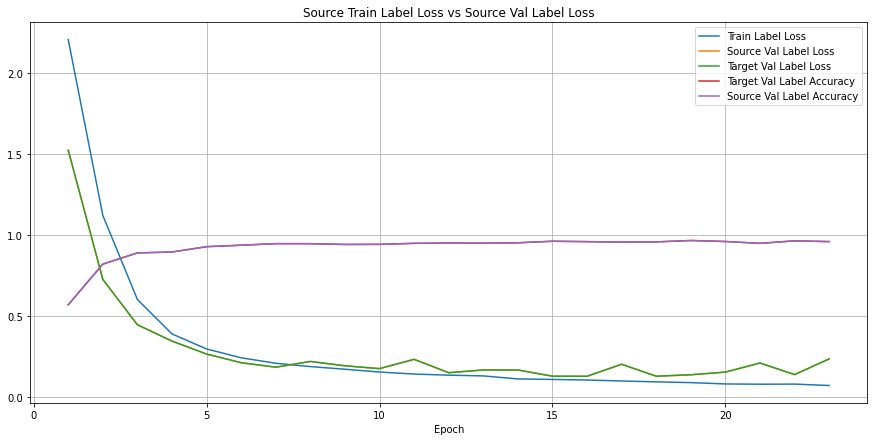

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

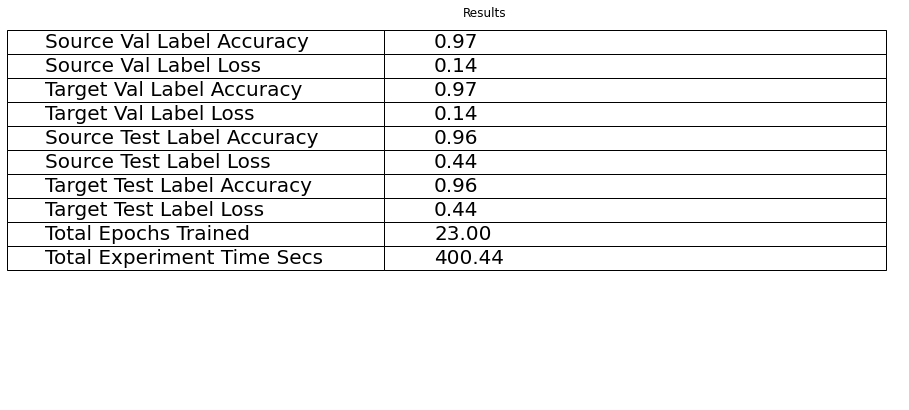

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

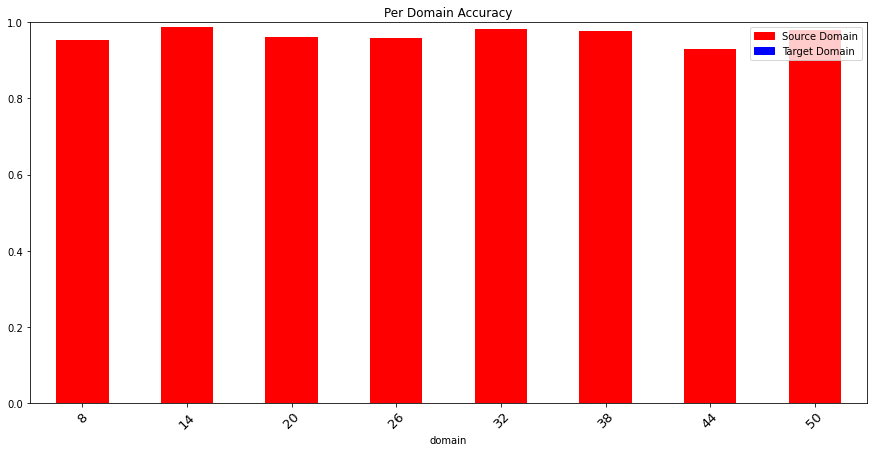

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9647135416666667 Target Test Label Accuracy: 0.9647135416666667
Source Val Label Accuracy: 0.966015625 Target Val Label Accuracy: 0.966015625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch